In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import re

train = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\train.csv", parse_dates=['timestamp'],index_col='id')
y_train = train['price_doc']
test =  pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\test.csv", parse_dates=['timestamp'],index_col='id')
macro = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\macro.csv", parse_dates=['timestamp'])
fix = pd.read_excel('C:\\Users\\user\\AnacondaProjects\\Sberbank\\BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id') 

train.update(fix,overwrite=True)
test.update(fix,overwrite=True)

In [2]:
train = train.reset_index()
test = test.reset_index()

In [3]:
y_train = train['price_doc']
id_test = test.id
train.drop(['price_doc','id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [4]:
#selecting only important macro columns
macro = macro[["timestamp","balance_trade","balance_trade_growth","eurrub","average_provision_of_build_contract","micex_rgbi_tr","micex_cbi_tr","deposits_rate","mortgage_value","mortgage_rate","income_per_cap","rent_price_4+room_bus","museum_visitis_per_100_cap","apartment_build"]]

In [5]:
# Build all_data = (train+test).join(macro)
num_train = len(train)
all_data = pd.concat([train, test])
all_data = pd.merge(all_data,macro,how='left',on='timestamp')

In [6]:
# Add month-year
month_year = (all_data.timestamp.dt.month + all_data.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
all_data['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (all_data.timestamp.dt.weekofyear + all_data.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
all_data['week_year_cnt'] = week_year.map(week_year_cnt_map)

In [7]:
# Creating Apartment Name Feature
all_data['apartment_name'] = all_data.sub_area + all_data['metro_km_avto'].astype(str)

In [8]:
#cleaning of full_sq 
#Following code will fix those records where full_sq are abnormally high or low and life_sq are normal.
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"]))),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"])))].life_sq

#based on apartment name feature fix abnormal high or low full_sq. Mode is ideal candidate here. but somehow it is not workign for me(I dont know how to code that :( )
g_Apartment_col=all_data.groupby('apartment_name')['full_sq'].agg(['mean','median','count']).reset_index()
g_Apartment_col.columns= ['apartment_name','full_sq_mean','full_sq_median','apartment_count'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3)].full_sq_mean

# we will drop median and mean but count considered as feature
all_data.drop("full_sq_median", axis=1, inplace=True)
all_data.drop("full_sq_mean", axis=1, inplace=True)

# Remove timestamp column (may overfit the model in train)
all_data.drop(['timestamp'], axis=1, inplace=True)

In [9]:
#very important cleaning now - price_doc
train = all_data[:num_train]
test  = all_data[num_train:]

train = pd.concat((train,y_train),axis=1)
train["prize_per_sqrmtr"]=train.price_doc/train.full_sq

# grouping by prize_per_sqrmtr
g_Apartment_col=train.groupby('apartment_name')['prize_per_sqrmtr'].agg(['mean','std']).reset_index()
g_Apartment_col.columns= ['apartment_name','pps_mean','pps_std'] 
train=train.merge(g_Apartment_col, how='left', on ='apartment_name')

# change value if more than 4 sigma
train.loc[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std)),"prize_per_sqrmtr"]=train[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std))].pps_mean

In [10]:
# If still some values doesnt seem correct, so clean it using sub_area
g_Apartment_col=train.groupby('sub_area')['prize_per_sqrmtr'].agg(['mean']).reset_index()
g_Apartment_col.columns= ['sub_area','sa_mean'] 
train=train.merge(g_Apartment_col, how='left', on='sub_area')
# Change if out of range
train.loc[ (train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=10000) ,"prize_per_sqrmtr"]= train[(train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=10000)].sa_mean


In [11]:
train["price_doc"]=train.prize_per_sqrmtr*train.full_sq

In [12]:
y_train = train['price_doc']
train.drop(['pps_mean','pps_std','sa_mean','prize_per_sqrmtr','price_doc'], axis=1, inplace=True)

In [13]:
all_data = pd.concat([train, test])

In [14]:
# cleaning life_sq
all_data.loc[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224),"life_sq"] =all_data[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224)].full_sq/1.66

In [15]:
# cleaning floor. Doesn't make sense to clean floor. It is possible same building get different floors
all_data.loc[(all_data.floor>48),"floor"]=np.NaN

In [16]:
# cleaning max_floor
g_Apartment_col=all_data.groupby('apartment_name')['floor'].agg(['max']).reset_index()
g_Apartment_col.columns= ['apartment_name','apartment_floor_max'] 
all_data=all_data.merge(g_Apartment_col, how='left',on='apartment_name')
# clean null or very high max_floor values, where apartment count is atleast 4
all_data.loc[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3),"max_floor"] = all_data[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3)].apartment_floor_max
all_data.drop(['apartment_floor_max'], axis=1, inplace=True)

In [17]:
# cleaning build_year : Same apartment will most likely have same build year
g_Apartment_col=all_data.groupby('apartment_name')['build_year'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','byear_mean']
all_data=all_data.merge( g_Apartment_col, how='left', on='apartment_name')
all_data.loc[(all_data.build_year<1950) | (all_data.build_year>2020)|(all_data.build_year.isnull()) , "build_year"]=all_data[(all_data.build_year<1950) | (all_data.build_year>2020)|(all_data.build_year.isnull())].byear_mean
all_data.drop(['byear_mean'], axis=1, inplace=True)

In [18]:
# cleaning num_room : if same apartment and same size then most likely number of room will be same
g_Apartment_col=all_data.groupby(['apartment_name','full_sq'])['num_room'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','full_sq','nrmedian']
all_data=pd.merge( all_data,g_Apartment_col, how='left', on=['apartment_name','full_sq'])
all_data.loc[((all_data.num_room>=7) & (all_data.full_sq<100)) | (all_data.num_room==0) | (all_data.num_room.isnull()),"num_room"]=all_data[((all_data.num_room>=7) & (all_data.full_sq<100)) | (all_data.num_room==0) | (all_data.num_room.isnull())].nrmedian
all_data.drop(['nrmedian'], axis=1, inplace=True)

In [19]:
all_data['rel_kitch_sq'] = all_data['kitch_sq'] / all_data['life_sq'].astype(float)

In [20]:
# cleaning kitch_sq
g_Apartment_col=all_data.groupby(['apartment_name','full_sq'])['rel_kitch_sq'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','full_sq','rksmedian']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on=['apartment_name','full_sq'])
all_data.loc[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5),"kitch_sq" ]=all_data[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5)].life_sq * all_data[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5)].rksmedian
all_data.loc[(all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull()),"kitch_sq"]=all_data[(all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())].life_sq * 0.23
all_data.drop(['rksmedian'], axis=1, inplace=True)

In [21]:
# cleaning state
g_Apartment_col=all_data[all_data.state>=0].groupby('apartment_name')['state'].agg(['median','mean']).reset_index()
g_Apartment_col.columns= ['apartment_name','state_median','state_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')

In [22]:
all_data.loc[((all_data.state.isnull())|(all_data.state>4))&(all_data.apartment_count>=5)&(all_data.state_median>=0) ,"state"]=all_data[((all_data.state.isnull())|(all_data.state>4))&(all_data.apartment_count>=5) & (all_data.state_median>=0)].state_median.astype(int)
all_data.drop(['state_median'], axis=1, inplace=True)
all_data.drop(['state_mean'], axis=1, inplace=True)

In [23]:
# cleaning material
g_Apartment_col=all_data[all_data.material>=0].groupby('apartment_name')['material'].agg(['median','mean']).reset_index()
g_Apartment_col.columns= ['apartment_name','mat_median','mat_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.material.isnull())|(all_data.material>6))&(all_data.apartment_count>=5)&(all_data.mat_median>=0) ,"material"]=all_data[((all_data.material.isnull())|(all_data.material>6))&(all_data.apartment_count>=5) & (all_data.mat_median>=0)].mat_median.astype(int)
all_data.drop(['mat_median'], axis=1, inplace=True)
all_data.drop(['mat_mean'], axis=1, inplace=True)
all_data.drop(['apartment_name'], axis=1, inplace=True)

In [24]:
all_data['rel_floor'] = all_data['floor'] / all_data['max_floor'].astype(float)
all_data['rel_kitch_sq'] = all_data['kitch_sq'] / all_data['full_sq'].astype(float)

In [25]:
all_data = pd.get_dummies(all_data, columns = ['sub_area'])

In [26]:
from sklearn import preprocessing 
#convert objects / non-numeric data types into numeric
for f in all_data.columns:
    if all_data[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(all_data[f].values)) 
        all_data[f] = lbl.transform(list(all_data[f].values))

In [27]:
X_train = all_data[:num_train]
X_test = all_data[num_train:]

df_columns = all_data.columns

In [28]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'min_child_weight' : 17
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=20, show_stdv=False)

[0]	train-rmse:8.19119e+06	test-rmse:8.19683e+06
[20]	train-rmse:3.89027e+06	test-rmse:4.00976e+06
[40]	train-rmse:2.69579e+06	test-rmse:2.94591e+06
[60]	train-rmse:2.38291e+06	test-rmse:2.70474e+06
[80]	train-rmse:2.27516e+06	test-rmse:2.63543e+06
[100]	train-rmse:2.21366e+06	test-rmse:2.60394e+06
[120]	train-rmse:2.16936e+06	test-rmse:2.58737e+06
[140]	train-rmse:2.13251e+06	test-rmse:2.5713e+06
[160]	train-rmse:2.10157e+06	test-rmse:2.56092e+06
[180]	train-rmse:2.07347e+06	test-rmse:2.55216e+06
[200]	train-rmse:2.04806e+06	test-rmse:2.5466e+06
[220]	train-rmse:2.02238e+06	test-rmse:2.54037e+06
[240]	train-rmse:1.99978e+06	test-rmse:2.53416e+06
[260]	train-rmse:1.97365e+06	test-rmse:2.52875e+06
[280]	train-rmse:1.95053e+06	test-rmse:2.52457e+06
[300]	train-rmse:1.92939e+06	test-rmse:2.51934e+06
[320]	train-rmse:1.91042e+06	test-rmse:2.51667e+06
[340]	train-rmse:1.89093e+06	test-rmse:2.51468e+06
[360]	train-rmse:1.8739e+06	test-rmse:2.51395e+06
[380]	train-rmse:1.85594e+06	test-rmse:2

In [29]:
num_boost_rounds = len(cv_result)

In [30]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

In [31]:
%matplotlib inline

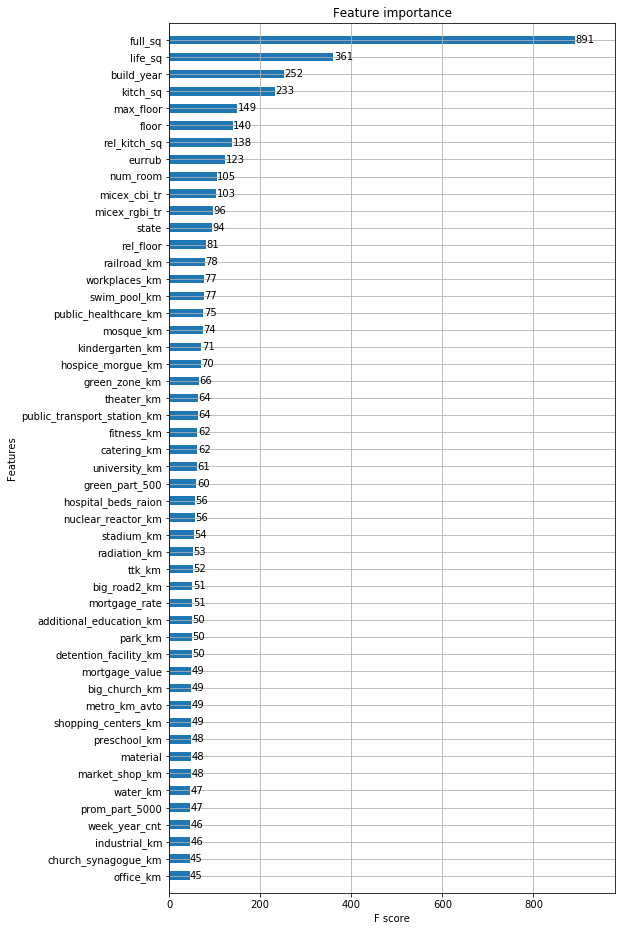

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [33]:
y_pred = model.predict(dtest)

In [34]:
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred })
df_sub.to_csv('subxgb.csv', index=False)